In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
import math
from math import sqrt

In [2]:
# .csv dosyasının pandas read_csv metodu ile okunarak "data" adlı değişkene atanması: 

data = pd.read_csv("tr_tuketim_guncel.csv")

# veri setinin ilk beş elemanı: 
data.head()

,Tarih,Saat,T�ketim Miktar� (MWh)
0,01.01.2017,00:00,"27.223,06"
1,01.01.2017,01:00,"25.825,90"
2,01.01.2017,02:00,"24.252,68"
3,01.01.2017,03:00,"22.915,47"
4,01.01.2017,04:00,"22.356,99"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51120 entries, 0 to 51119
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Tarih                  51120 non-null  object
 1   Saat                   51120 non-null  object
 2   T�ketim Miktar� (MWh)  51120 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [4]:
# veri setinin bir kopyasını oluturup "df" adlı bir değişkene atanması:

df = data.copy()

# kolon isimlerinin anlaşılır hale getirilmesi, tarih belirten kolonun datetime formatına çevrilmesi:

df['Tarih'] =pd.to_datetime(df['Tarih'] +' '+ df['Saat'], format='%d.%m.%Y %H:%M')

df = df.drop(columns = ["Saat"])
df = df.rename(columns={'T�ketim Miktar� (MWh)':'Tuketim'})

# tüketim değerlerini ifade eden "consumption" kolonundaki verilerin string tipinden float tipine dönüştürülmesi:

df['Tuketim'] = df['Tuketim'].str.replace('.', "" ,regex=True)
df["Tuketim"] = df["Tuketim"].str.replace(',', '.')
df["Tuketim"] = df["Tuketim"].astype(float)

df = df[["Tarih","Tuketim"]]

df.head()

,Tarih,Tuketim
0,2017-01-01 00:00:00,27223.06
1,2017-01-01 01:00:00,25825.90
2,2017-01-01 02:00:00,24252.68
3,2017-01-01 03:00:00,22915.47
4,2017-01-01 04:00:00,22356.99


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51120 entries, 0 to 51119
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tarih    51120 non-null  datetime64[ns]
 1   Tuketim  51120 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 798.9 KB


In [6]:
# saatlik frekanstaki verilerin günlük frekansa çekilmesi,
# "Tarih" kolonunun indeks olarak verilmesi ve data_daily adlı değişkene atanması:

data_daily = df.set_index("Tarih").asfreq('D')
data_daily.head()

,Tuketim
Tarih,
2017-01-01,27223.06
2017-01-02,27477.70
2017-01-03,30859.74
2017-01-04,31313.51
2017-01-05,31433.88


In [7]:
data_daily.describe()

,Tuketim
count,2130.000000
mean,32653.296742
std,3321.932504
min,20627.680000
25%,30389.485000
50%,32360.350000
75%,34677.085000
max,44984.420000


In [8]:
# kayıp veri kontrolü :

data_daily.isnull().sum()

Tuketim    0
dtype: int64

In [9]:
# yinelenen (duplike) veri kontrolü:

duplicate = data_daily[data_daily.duplicated()]
 
print("Duplicate Rows :")
duplicate

Duplicate Rows :


,Tuketim
Tarih,
2019-01-06,30573.30
2019-01-26,31701.58
2022-01-10,32456.36


In [10]:
# duplike verilerin drop edilmesi: 

data_daily.drop_duplicates(inplace=True)

In [11]:
# duplike verilerin drop edilmesinden sonra tekrar kontrol edilmesi: 

duplicate = data_daily[data_daily.duplicated()]
 
print("Duplicate Rows :")
duplicate

Duplicate Rows :


,Tuketim
Tarih,


<AxesSubplot:xlabel='Tarih', ylabel='Tuketim'>

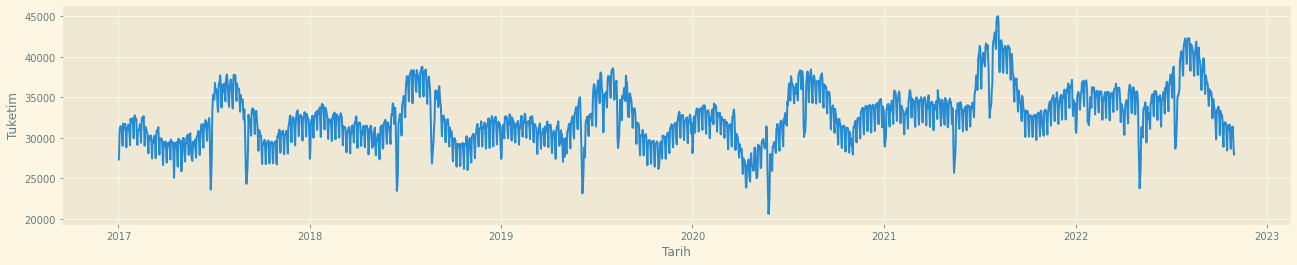

In [12]:
# verilerin çizgi grafiği üzerinde gösterilmesi:

plt.figure(figsize=(22,4))
sns.lineplot(data = data_daily.reset_index(), x="Tarih", y="Tuketim")

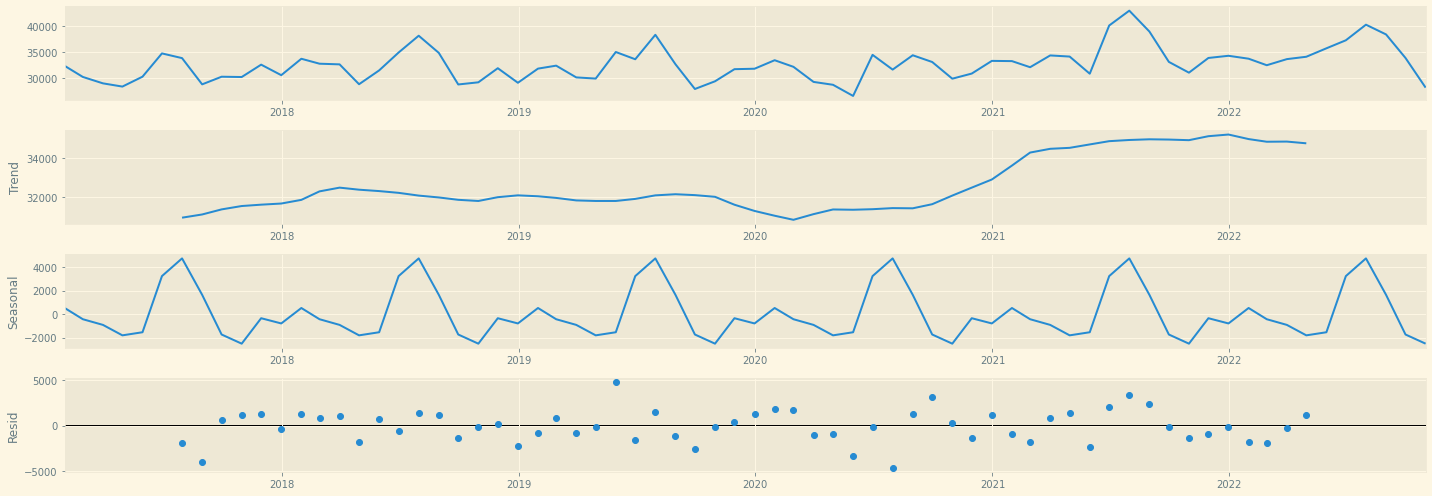

In [13]:
# zaman serisi bileşenleri: 

data_monthly = df.set_index("Tarih").asfreq('M')

plt.rcParams['figure.figsize'] = [20,7]
decomposition = sm.tsa.seasonal_decompose(data_monthly)
fig = decomposition.plot()
plt.show()

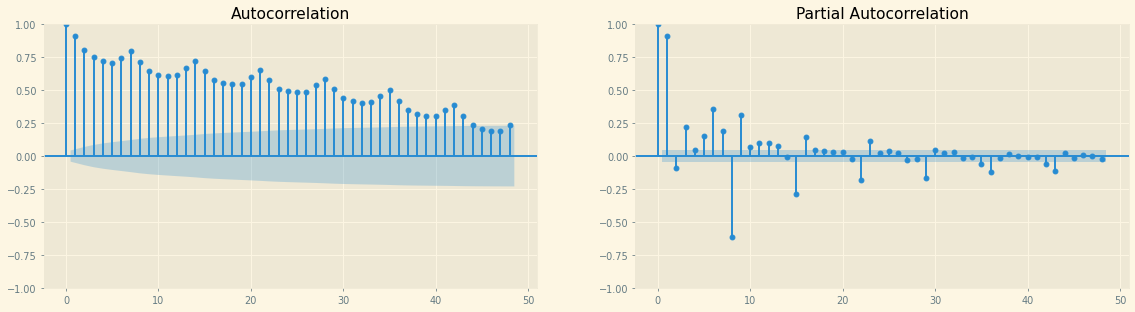

In [14]:
# otokorelasyon ve kısmı otokorelasyon grafikleri (ACF-PACF): 

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)

plot_acf(data_daily.Tuketim.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily.Tuketim.tolist(), ax=ax2, lags=48, method="ywm")

plt.show()

1- Augmented Dickey-Fuller Test 
* Sıfır Hipotez H0 : Seri Durağan Değildir
* Alternati Hipotez H1 : Seri Durağandır (Birim Kök Yoktur)

2- Kwiatkowski-Phillips-Schmidt-Shin Test
* Sıfır Hipotez H0 : Seri Durağandır (Birim Kök Yoktur)
* Alternati Hipotez H1: Seri durağan değildir

In [15]:
# ADF Testi:

def adf(data):
    adf_test = sm.tsa.adfuller(data, autolag='AIC')
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    print("Seri Durağan Değildir") if adf_test[1] > 0.05 else print("Seri Durağandır(Birim Kök Yoktur)")

# KPSS Testi:

def kpss(data):
    kpss_test = sm.tsa.kpss(data)
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print("Seri Durağandır") if kpss_test[1] > 0.05 else print("Seri durağan değildir(Seri Birim Kök İçerir)")

adf(data_daily)
print()
kpss(data_daily)

ADF Statistic: -3.721810325272013
p-value: 0.0038166240916141804
Seri Durağandır(Birim Kök Yoktur)

KPSS Statistic: 2.007418
p-value: 0.010000
Seri durağan değildir(Seri Birim Kök İçerir)


/home/merve/notebooks/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2011: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [16]:
# ADF testi bir birim kök bulamazsa, ancak KPSS testi bulursa, seri fark durağandır ve yine de fark alınması gerekir.

In [17]:
data_daily_diff = data_daily.copy()
data_daily_diff['Tuketim'] = data_daily['Tuketim'] - data_daily['Tuketim'].shift(1)
data_daily_diff = data_daily_diff.dropna()

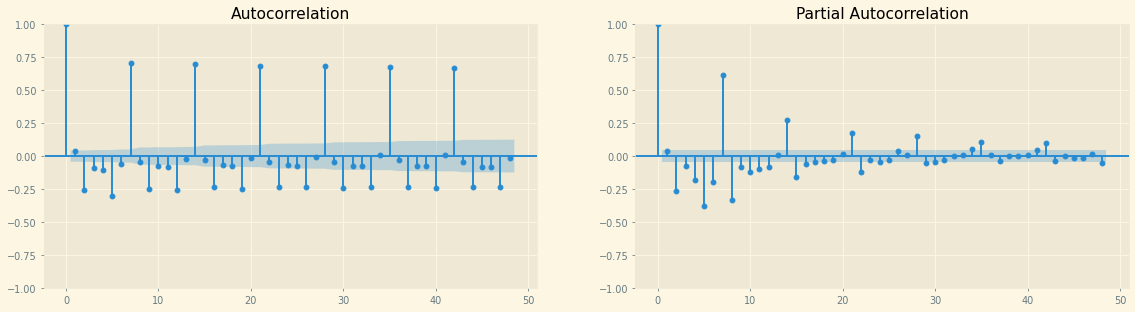

In [18]:
#  birinci dereceden farkı alınan serinin ACF ve PACF grafikleri:

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)

plot_acf(data_daily_diff.Tuketim.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily_diff.Tuketim.tolist(), ax=ax2, lags=48, method="ywm")

plt.show()

In [19]:
#  birinci dereceden farkı alınan serinin ADF-KPSS testleri: 

adf(data_daily)
print()
kpss(data_daily)

ADF Statistic: -3.721810325272013
p-value: 0.0038166240916141804
Seri Durağandır(Birim Kök Yoktur)

KPSS Statistic: 2.007418
p-value: 0.010000
Seri durağan değildir(Seri Birim Kök İçerir)


/home/merve/notebooks/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2011: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [20]:
# birinci dereceden farkı alınan seri üzerinde mevsimsel fark uygulanması: 

data_daily_diff2 = data_daily_diff.diff(7).dropna()

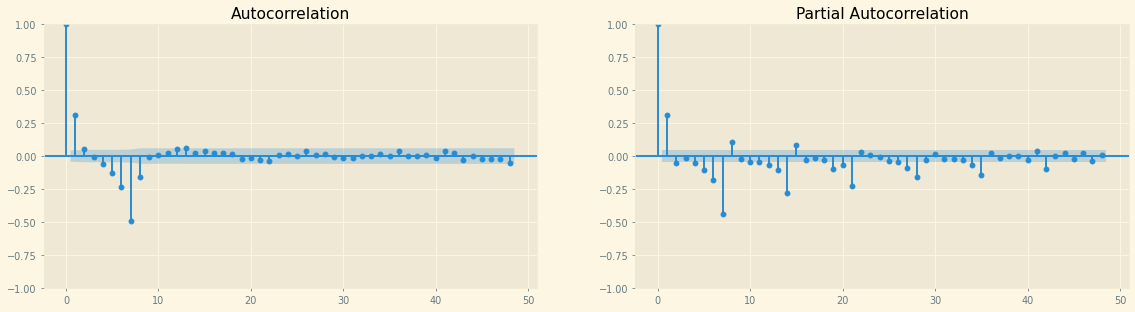

In [21]:
#  ACF ve PACF plot

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)

plot_acf(data_daily_diff2.Tuketim.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily_diff2.Tuketim.tolist(), ax=ax2, lags=48)

plt.show()

In [22]:
# veri setinin eğitim ve test seti olarak ayrıştırılması : 

train_data = data_daily[:'2022-07-31']
test_data = data_daily['2022-08-01':'2022-08-31']
pred_df = test_data.copy()

<AxesSubplot:xlabel='Tarih'>

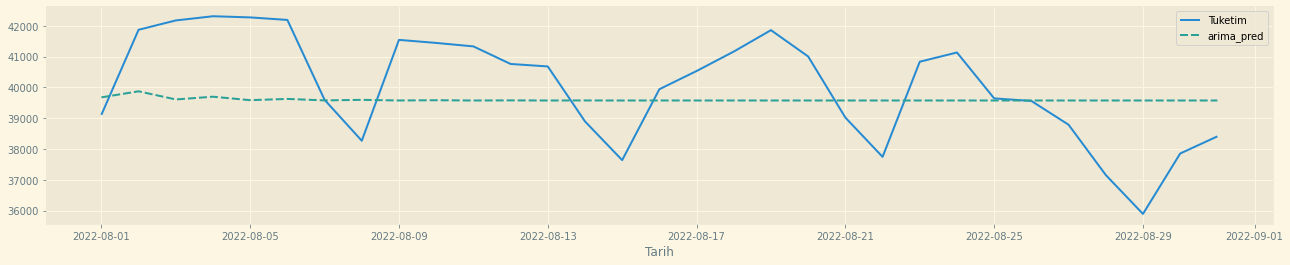

In [23]:
# ARIMA (2,1,2)

arima_model = sm.tsa.arima.ARIMA(np.asarray(train_data),order=(2,1,2))
arima_model_fit = arima_model.fit()
arima_pred = arima_model_fit.forecast(len(test_data),disp=False)

pred_df["arima_pred"] = arima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(data = pred_df[['Tuketim', 'arima_pred']])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21310D+00    |proj g|=  1.80722D-01

At iterate    5    f=  8.17815D+00    |proj g|=  1.62962D-02

At iterate   10    f=  8.17741D+00    |proj g|=  6.95957D-04

At iterate   15    f=  8.17457D+00    |proj g|=  1.95546D-02

At iterate   20    f=  8.16589D+00    |proj g|=  8.96480D-03

At iterate   25    f=  8.16457D+00    |proj g|=  6.39728D-03

At iterate   30    f=  8.16443D+00    |proj g|=  5.49012D-04

At iterate   35    f=  8.16270D+00    |proj g|=  3.84073D-02

At iterate   40    f=  8.14394D+00    |proj g|=  1.39578D-02

At iterate   45    f=  8.13393D+00    |proj g|=  2.16774D-03

At iterate   50    f=  8.12672D+00    |proj g|=  3.13902D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/merve/notebooks/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='Tarih'>

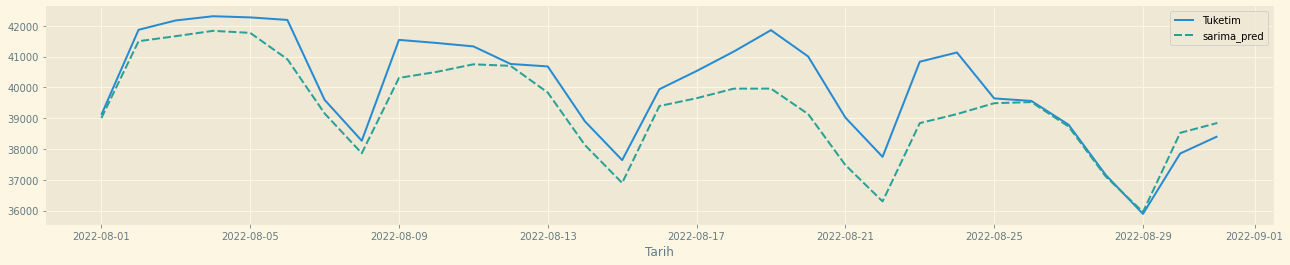

In [24]:
# SARIMA (2,1,2) (1,1,1,7)

sarima_model = SARIMAX(np.asarray(train_data), order=(2, 1, 2), seasonal_order=(1,1,1,7))
sarima_model_fit = sarima_model.fit()
sarima_pred = sarima_model_fit.forecast(len(test_data))

pred_df["sarima_pred"] = sarima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(data = pred_df[['Tuketim', 'sarima_pred']])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.2494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5777.09    0.00681955       915.574           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5785.14    0.00339043       270.754           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276        5787.8   4.17329e-05       88.5189   2.075e-07       0.001      406  LS failed, Hessian reset 
     299       5788.32   0.000446875       142.583      0.5344      0.5344      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     386       5790.01   8.69885e-05       235.954   4.225e-07       0.001      581  LS failed, Hessian reset 
     399       5790.85   0.000120775       145.075     0.05013      0.2288      597   
    Iter      log pro

<AxesSubplot:xlabel='Tarih'>

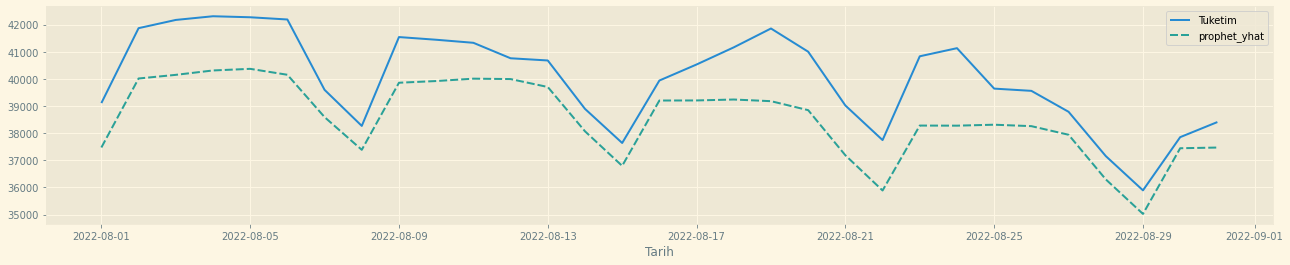

In [25]:
# PROPHET

prophet_df = data_daily.reset_index()
prophet_df.columns = ["ds","y"]

train_data_prophet = prophet_df[prophet_df['ds'] < '2022-08-01']
test_data_prophet = prophet_df[(prophet_df['ds'] >= '2022-08-01') & (prophet_df['ds'] <= '2022-08-31')]

prophet_model = Prophet()
prophet_model.fit(train_data_prophet)
model_predict = prophet_model.predict(test_data_prophet)

pred_df["prophet_yhat"] = model_predict["yhat"].values.round(2)
pred_df["prophet_yhat_lower"] = model_predict["yhat_lower"].values.round(2)
pred_df["prophet_yhat_upper"] = model_predict["yhat_upper"].values.round(2)

plt.figure(figsize=(22,4))
sns.lineplot(data = pred_df[['Tuketim', 'prophet_yhat']])

<AxesSubplot:xlabel='Tarih'>

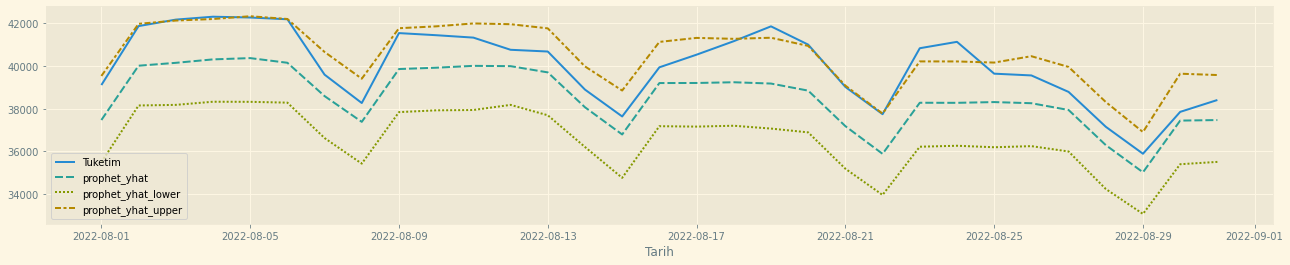

In [26]:
plt.figure(figsize=(22,4))
sns.lineplot(data = pred_df[['Tuketim', 'prophet_yhat', 'prophet_yhat_lower','prophet_yhat_upper']])

In [27]:
prophet_mape = mean_absolute_percentage_error(pred_df["Tuketim"].values, pred_df["prophet_yhat"].values)
prophet_r = r2_score(pred_df["Tuketim"].values, pred_df["prophet_yhat"].values)
prophet_rmse = math.sqrt(mean_squared_error(pred_df["Tuketim"].values, pred_df["prophet_yhat"].values))

arima_mape = mean_absolute_percentage_error(pred_df["Tuketim"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["Tuketim"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["Tuketim"].values, pred_df["arima_pred"].values))

sarima_mape = mean_absolute_percentage_error(pred_df["Tuketim"].values, pred_df["sarima_pred"].values)
sarima_r = r2_score(pred_df["Tuketim"].values, pred_df["sarima_pred"].values)
sarima_rmse = math.sqrt(mean_squared_error(pred_df["Tuketim"].values, pred_df["sarima_pred"].values))

results = {'Prophet': [prophet_mape,prophet_rmse,prophet_r], 
        'ARIMA': [arima_mape,arima_rmse,arima_r],
        'SARIMA': [sarima_mape,sarima_rmse,sarima_r]}
results = pd.DataFrame(results,index=['MAPE','RMSE','R2'])
results

,Prophet,ARIMA,SARIMA
MAPE,0.036527,0.037491,0.019245
RMSE,1602.794453,1735.551083,987.476500
R2,0.110701,-0.042718,0.662444
